# Generative Adversarial Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
import os
import imageio

In [295]:
import sys

%matplotlib notebook
import numpy as np

from IPython.core.debugger import Tracer

from keras.datasets import mnist, cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt
plt.switch_backend('agg')


class GAN(object):
    def __init__(self, width = 32, height= 32, channels = 3):

        self.WIDTH = width
        self.HEIGHT = height
        self.CHANNELS = channels

        self.SHAPE = (self.WIDTH, self.HEIGHT, self.CHANNELS)

        self.OPTIMIZER = Adam(lr=0.002, decay=8e-9)

        self.noise_gen = np.random.normal(0,1,(100,))

        self.G = self.generator()
        self.G.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER)

        self.D = self.discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER, metrics=['accuracy'] )

        self.stacked_G_D = self.stacked_G_D()

        self.stacked_G_D.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER)

    def generator(self):

        model = Sequential()
        model.add(Dense(256, input_shape=(100,)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.WIDTH * self.HEIGHT * self.CHANNELS, activation='tanh'))

        model.add(Reshape((self.WIDTH, self.HEIGHT, self.CHANNELS)))

        return model

    def discriminator(self):

        model = Sequential()
        model.add(Flatten(input_shape=self.SHAPE))
        model.add(Dense((self.WIDTH * self.HEIGHT * self.CHANNELS), input_shape=self.SHAPE))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(int((self.WIDTH * self.HEIGHT * self.CHANNELS)/2)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        return model

    def stacked_G_D(self):
        self.D.trainable = False

        model = Sequential()
        model.add(self.G)
        model.add(self.D)

        return model

    def train(self, X_train, epochs=20000, batch = 512, save_interval = 100):

        for cnt in range(30000):

            ## train discriminator
            random_index =  np.random.randint(0, len(X_train) - int(batch/2))
            legit_images = X_train[random_index : random_index + int(batch/2)]
            legit_images = legit_images.reshape(int(batch/2), self.WIDTH, self.HEIGHT, self.CHANNELS)

            gen_noise = np.random.normal(0, 1, (int(batch/2),100))
            syntetic_images = self.G.predict(gen_noise)

            x_combined_batch = np.concatenate((legit_images, syntetic_images))
            y_combined_batch = np.concatenate((np.ones((int(batch/2), 1)), np.zeros((int(batch/2), 1))))

            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)


#         for cnt in range(400):
            # train generator

            noise = np.random.normal(0, 1, (batch,100))
            y_mislabled = np.ones((batch, 1))

            g_loss = self.stacked_G_D.train_on_batch(noise, y_mislabled)

            if cnt % 5 == 0:
                print ('epoch: %d, [Discriminator :: d_loss: %f] [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss))

            if cnt % 200 == 0 : 
                self.save_images(cnt=cnt)

    def save_images(self, cnt, samples=10):
        noise = np.random.normal(0, 1, (samples,100))

        images = self.G.predict(noise)
        for ix, image in enumerate(images):
#             image = image.reshape(32, 32)
            if not os.path.exists('results/{:05d}'.format(cnt)):
                os.makedirs('results/{:05d}'.format(cnt))
            imageio.imwrite('results/{:05d}/{}.jpg'.format(cnt, ix), image)


In [296]:
(X_train, y_train), (_, _) = cifar10.load_data()
X_train = X_train[np.where(y_train == 3)[0]]
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

# X_train = np.zeros((50000, 32, 32, 3))
# X_train[:, 10:22, 10:22] = 1

In [297]:
gan = GAN()
gan.train(X_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_40 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_257 (Dense)            (None, 3072)              9440256   
_________________________________________________________________
leaky_re_lu_178 (LeakyReLU)  (None, 3072)              0         
_________________________________________________________________
dense_258 (Dense)            (None, 1536)              4720128   
_________________________________________________________________
leaky_re_lu_179 (LeakyReLU)  (None, 1536)              0         
_________________________________________________________________
dense_259 (Dense)            (None, 1)                 1537      
Total params: 14,161,921
Trainable params: 14,161,921
Non-trainable params: 0
________________________________________________________________

/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, [Discriminator :: d_loss: 0.735143] [ Generator :: loss: 0.000000]
epoch: 5, [Discriminator :: d_loss: 5.769226] [ Generator :: loss: 4.549076]
epoch: 10, [Discriminator :: d_loss: 5.214210] [ Generator :: loss: 6.591758]
epoch: 15, [Discriminator :: d_loss: 5.510895] [ Generator :: loss: 7.896137]
epoch: 20, [Discriminator :: d_loss: 5.981485] [ Generator :: loss: 8.348877]
epoch: 25, [Discriminator :: d_loss: 5.916197] [ Generator :: loss: 12.367967]
epoch: 30, [Discriminator :: d_loss: 3.122961] [ Generator :: loss: 15.015701]
epoch: 35, [Discriminator :: d_loss: 2.366382] [ Generator :: loss: 14.197783]
epoch: 40, [Discriminator :: d_loss: 1.467108] [ Generator :: loss: 14.799531]
epoch: 45, [Discriminator :: d_loss: 1.135448] [ Generator :: loss: 14.008897]
epoch: 50, [Discriminator :: d_loss: 1.161300] [ Generator :: loss: 13.986486]
epoch: 55, [Discriminator :: d_loss: 1.710528] [ Generator :: loss: 12.749670]
epoch: 60, [Discriminator :: d_loss: 1.808744] [ Generator 

epoch: 200, [Discriminator :: d_loss: 5.423465] [ Generator :: loss: 7.051669]
epoch: 205, [Discriminator :: d_loss: 5.585421] [ Generator :: loss: 6.979977]
epoch: 210, [Discriminator :: d_loss: 5.707766] [ Generator :: loss: 6.359095]
epoch: 215, [Discriminator :: d_loss: 5.739246] [ Generator :: loss: 6.012807]
epoch: 220, [Discriminator :: d_loss: 6.300064] [ Generator :: loss: 5.603558]
epoch: 225, [Discriminator :: d_loss: 5.705020] [ Generator :: loss: 5.320232]
epoch: 230, [Discriminator :: d_loss: 5.392616] [ Generator :: loss: 5.540597]
epoch: 235, [Discriminator :: d_loss: 5.610235] [ Generator :: loss: 5.257271]
epoch: 240, [Discriminator :: d_loss: 5.798433] [ Generator :: loss: 5.666520]
epoch: 245, [Discriminator :: d_loss: 6.051651] [ Generator :: loss: 5.540597]
epoch: 250, [Discriminator :: d_loss: 5.520254] [ Generator :: loss: 5.886884]
epoch: 255, [Discriminator :: d_loss: 6.236759] [ Generator :: loss: 5.666520]
epoch: 260, [Discriminator :: d_loss: 5.676628] [ Ge

epoch: 400, [Discriminator :: d_loss: 7.971192] [ Generator :: loss: 0.000000]
epoch: 405, [Discriminator :: d_loss: 7.971192] [ Generator :: loss: 0.000000]
epoch: 410, [Discriminator :: d_loss: 7.971192] [ Generator :: loss: 0.000000]
epoch: 415, [Discriminator :: d_loss: 7.971192] [ Generator :: loss: 0.000000]
epoch: 420, [Discriminator :: d_loss: 7.971192] [ Generator :: loss: 0.000000]
epoch: 425, [Discriminator :: d_loss: 8.002672] [ Generator :: loss: 0.000000]


KeyboardInterrupt: 

In [196]:
gen_noise = np.random.normal(0, 1, (16,100))

In [200]:
result = gan.G.predict(gen_noise)[1]

In [201]:
result = result.reshape(28, 28)

In [204]:
import scipy.misc
scipy.misc.imsave('results/outfile.jpg', result)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


FileNotFoundError: [Errno 2] No such file or directory: 'results/123/outfile.jpg'

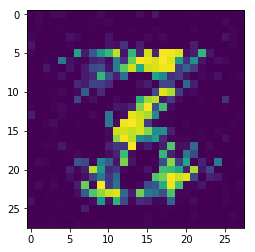

In [202]:
%matplotlib inline
plt.imshow(result)

<IPython.core.display.Javascript object>


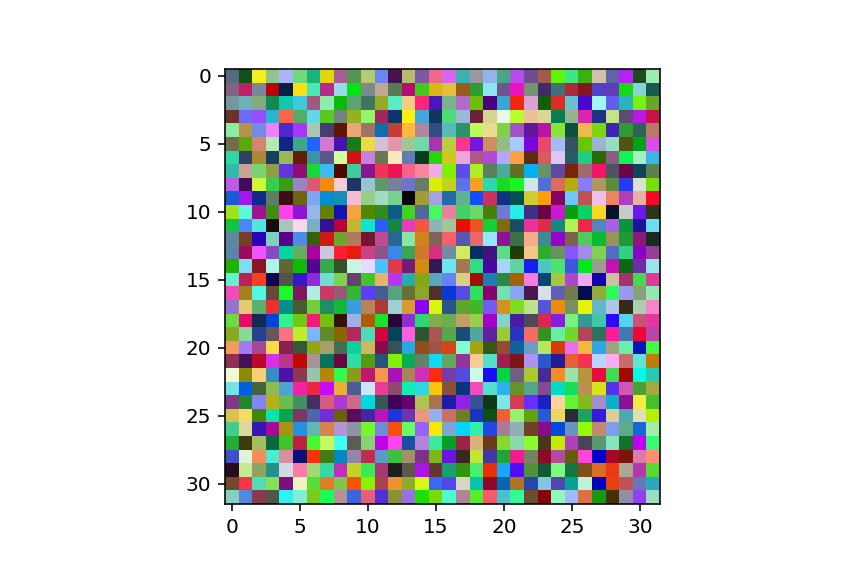

In [61]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

m = 100
n = 100
matrix = np.random.normal(0,1,m*n).reshape(m,n)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(0,100):
    ax.clear()
    ax.imshow(np.random.random((32, 32, 3)))
    fig.canvas.draw()

<IPython.core.display.Javascript object>


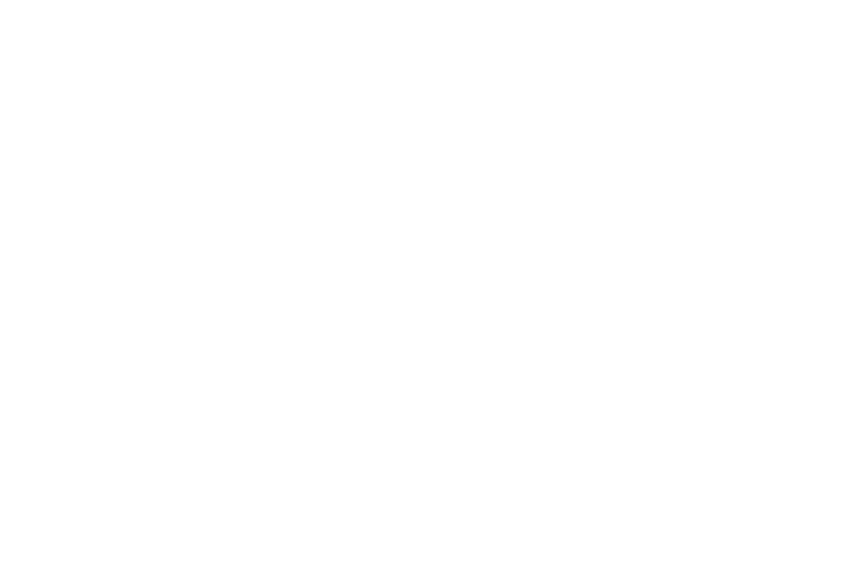

<IPython.core.display.Javascript object>


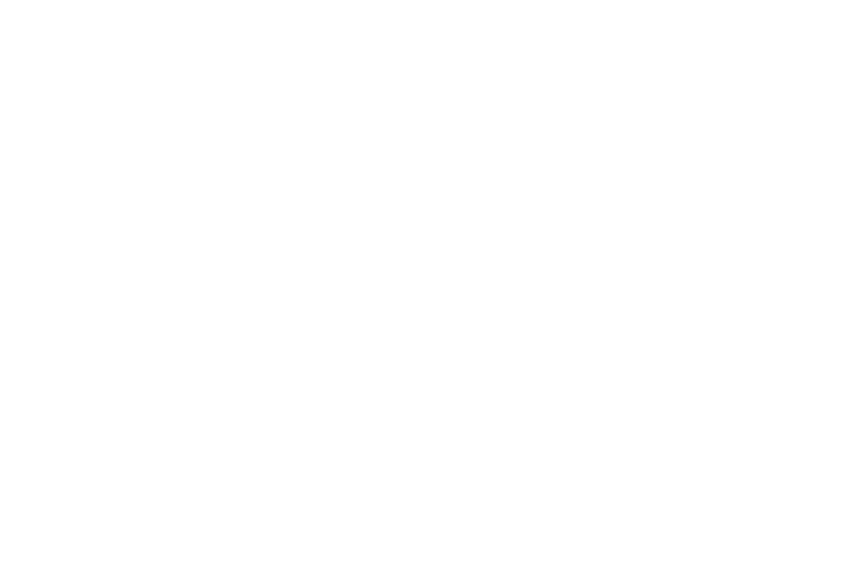

In [55]:
%matplotlib notebook
for i in range(5):
    plt.imshow(np.random.random((32, 32, 3)))
    time.sleep(1)